In [2]:
import baccoemu
import numpy as np
import pickle
import sacc
import pyccl as ccl
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from tools import get_cov

2024-02-07 16:10:08.842688: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 16:10:08.844695: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 16:10:08.878896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 16:10:08.878928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 16:10:08.879869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Do PCA in Mpc

In [3]:
# Load the data
with open('NN_emulator_PCA7_0.99_200_400n_paired_ext_new_accuracy_data.pickle', 'rb') as f:
    data = pickle.load(f)

# > dict_keys(['k', 'delta_p', 'delta_p_cov', 'data_mean', 'data_std', 'standardized_data', 'sorted_eigenvalues', 'sorted_eigenvectors'])

# Print the keys and shapes
for k, v in data.items():
    try:
        print(k, v.shape)
    except:
        print(k, len(v))

k (174,)
delta_p (64, 174)
delta_p_cov (174, 174)
data_mean (174,)
data_std (174,)
standardized_cov (174, 174)
standardized_data (64, 174)
sorted_eigenvalues (174,)
sorted_eigenvectors (174, 174)
cosmologies 64
cosmo_par_names 9


In [4]:
# Transform the data from h/Mpc to 1/Mpc
# h/Mpc -> 1/Mpc
h = np.array(data['cosmologies'])[:, 4]
kMpc = data['k'][:, None] * h 
kMpc = kMpc.T
print(kMpc.shape)

# Create a common set of k values in [1/Mpc]
kMpc_common = np.logspace(np.log10(kMpc[:, 0].max()+1e-6), np.log10(kMpc[:, -1].min()), 174)

# Pk [Mpc/h]^3 -> [Mpc]^3
delta_p_Mpc3 = data['delta_p'] / h[:, None]**3
delta_p_Mpc3_common = np.zeros((len(data['cosmologies']), kMpc_common.size))

# Interpolate the data and evaluate it in the common values of k [1/Mpc].
# Note that because delta_p can be negative, we don't use the logarithm
for i in range(len(data['cosmologies'])):
    delta_p_Mpc3_common[i, :] = interp1d(np.log(kMpc[i]), delta_p_Mpc3[i])(np.log(kMpc_common))
    
# Therefore, the variables to use are:
# kMpc_common, delta_p_Mpc3_common

print(delta_p_Mpc3_common.shape)

(64, 174)
(64, 174)


Precision in the reconstructed delta_p achieved at N = 63


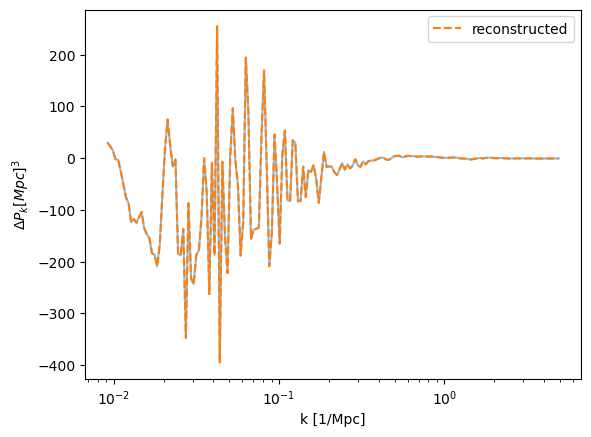

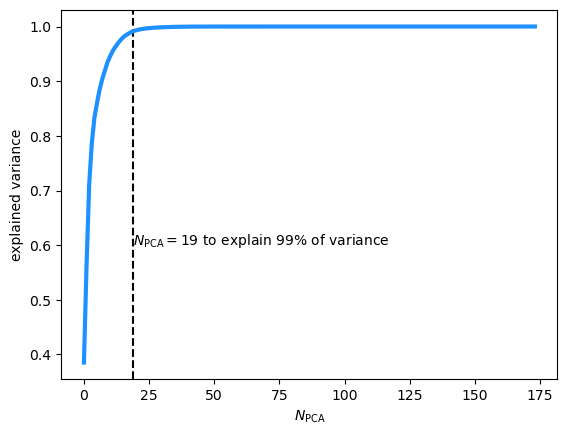

In [5]:
# Decompose delta_p_Mpc3_common in PCA

delta_p = delta_p_Mpc3_common
data_mean = np.mean(delta_p, axis=0)
data_std = np.std(delta_p, axis=0)

# First standarize the data
standarized_data = (delta_p - data_mean) / data_std
# Find the eigenvalues and eigenvectors
evk, vk = np.linalg.eigh(np.cov(standarized_data.T))
# Order the eigenvectors and eigenvalues in decreasing order
sorted_indices = np.argsort(evk)[::-1]
evk = evk[sorted_indices]
vk = vk[:, sorted_indices]

for N in range(evk.size):
    reduced_data = np.matmul(standarized_data, vk[:, :N]) # transform the original data
    reconstructed = data_std * np.matmul(reduced_data, vk[:, :N].T) + data_mean
    rdev = reconstructed / delta_p - 1
    if np.abs(rdev).max() < 0.01:
        print('Precision in the reconstructed delta_p achieved at N =', N)
        break

plt.semilogx(kMpc_common, delta_p[0], alpha=0.5)
plt.semilogx(kMpc_common, reconstructed[0], ls='--', label='reconstructed')
plt.xlabel('k [1/Mpc]')
plt.ylabel('$\Delta P_k [Mpc]^3$')
plt.legend()
plt.show()
plt.close()

# use sorted_eigenvalues to ensure the explained variances correspond to the eigenvectors
explained_variance = evk / np.sum(evk)

fix, ax = plt.subplots(1, 1)
index = np.where(np.cumsum(explained_variance) >= 0.99)[0][0]
# print(r'$N_{{\rm PCA}} = {}$ to explain 99% of variance'.format(index))
ax.axvline(index, color='k', ls='--')
ax.plot(np.cumsum(explained_variance), lw=3, color='dodgerblue')
ax.set_xlabel(r'$N_{\rm PCA}$')
ax.set_ylabel(r'explained variance')
ax.text(index, 0.6, r'$N_{{\rm PCA}} = {}$ to explain 99% of variance'.format(index))
plt.show()

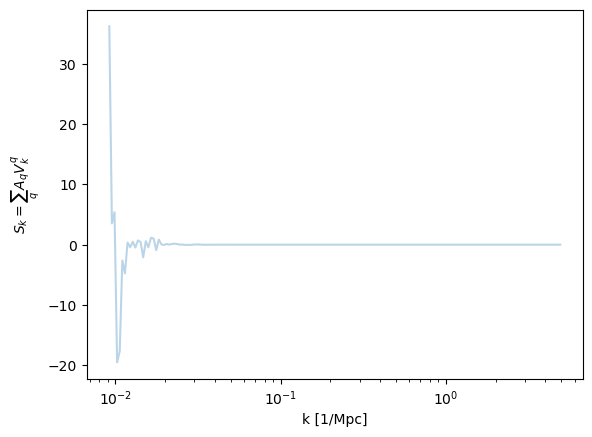

In [6]:
# Plot the components of standarized variable Sk (see notes)
plt.semilogx(kMpc_common, np.sum(evk*vk.T, axis=0), alpha=0.3)
plt.xlabel('k [1/Mpc]')
plt.ylabel('$S_k = \sum_q A_q V^q_k$')
plt.show()
plt.close()

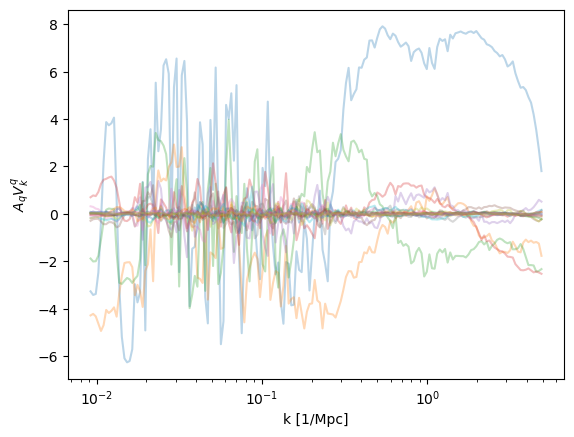

In [7]:
# Plot the components of standarized variable Sk (see notes)
for i in range(index):
    plt.semilogx(kMpc_common, evk[i]*vk[:, i], alpha=0.3)
plt.xlabel('k [1/Mpc]')
plt.ylabel('$A_q V^q_k$')
plt.show()
plt.close()

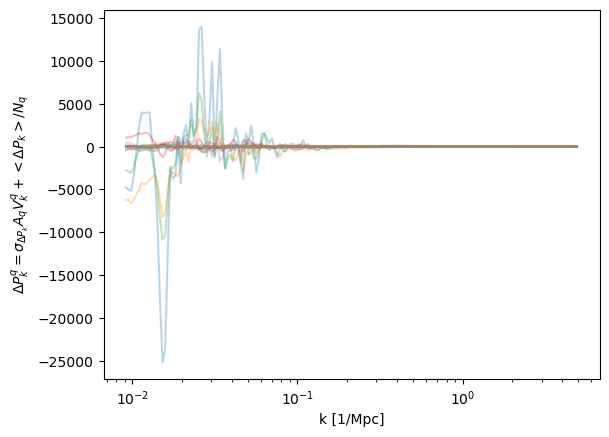

In [8]:
# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk = data_std * evk[i] * vk[:, i] + data_mean / index
    plt.semilogx(kMpc_common, DeltaPk, alpha=0.3)
plt.xlabel('k [1/Mpc]')
plt.ylabel('$\Delta P_k^q = \sigma_{\Delta P_k} A_q V^q_k + <\Delta P_k> / N_q$')
plt.show()
plt.close()

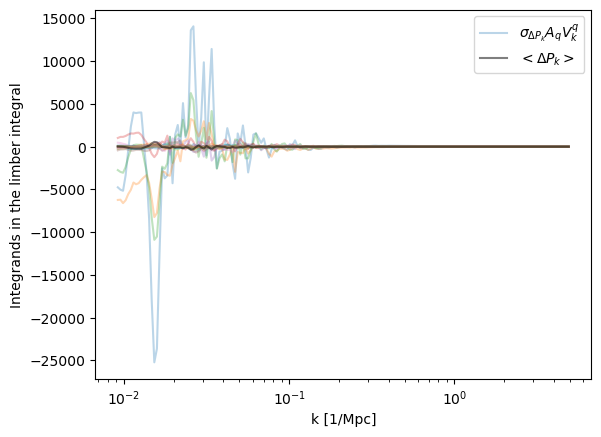

In [9]:
# But, actually, we probably don't want to integrate that quantity directly.
# Instead, we should integrate data_std * evk[i] * vk[:, i], and data_mean separately.

# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk_part1 = data_std * evk[i] * vk[:, i] 
    plt.semilogx(kMpc_common, DeltaPk_part1, alpha=0.3,
                 label=r'$\sigma_{\Delta P_k} A_q V^q_k$' if i ==0 else '')
plt.semilogx(kMpc_common, data_mean, color='k', alpha=0.5, label='$<\Delta P_k>$')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Integrands in the limber integral')
plt.legend()
plt.show()
plt.close()

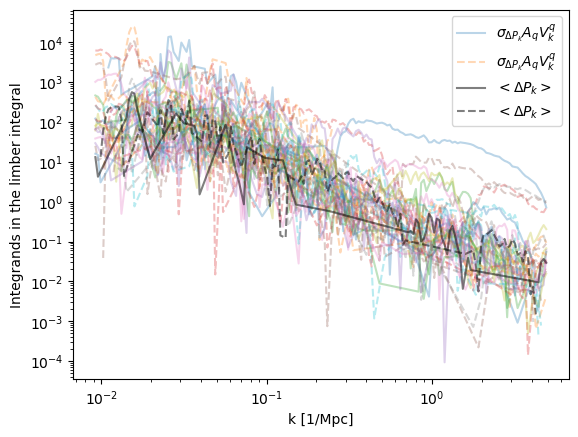

In [89]:
# But, actually, we probably don't want to integrate that quantity directly.
# Instead, we should integrate data_std * evk[i] * vk[:, i], and data_mean separately.

# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk_part1 = data_std * evk[i] * vk[:, i] 
    plt.semilogx(kMpc_common[DeltaPk_part1>0], DeltaPk_part1[DeltaPk_part1>0], alpha=0.3,
                 label=r'$\sigma_{\Delta P_k} A_q V^q_k$' if i ==0 else '')
    plt.semilogx(kMpc_common[DeltaPk_part1<0], -DeltaPk_part1[DeltaPk_part1<0], alpha=0.3, ls='--',
                 label=r'$\sigma_{\Delta P_k} A_q V^q_k$' if i ==0 else '')

plt.loglog(kMpc_common[data_mean>0], data_mean[data_mean>0], color='k', alpha=0.5, label='$<\Delta P_k>$')
plt.loglog(kMpc_common[data_mean<0], -data_mean[data_mean<0], color='k', alpha=0.5, ls='--', label='$<\Delta P_k>$')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Integrands in the limber integral')
plt.legend()
plt.show()
plt.close()

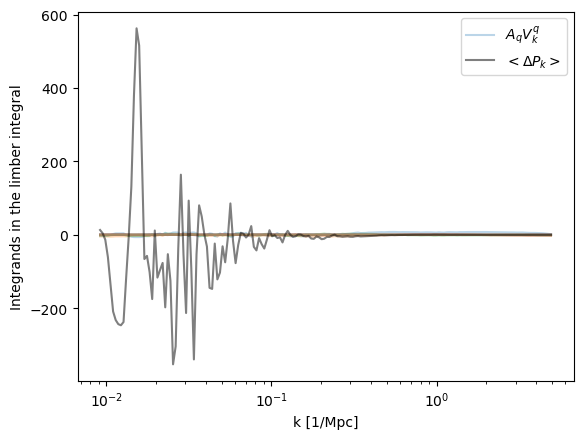

In [10]:
# Even better, we can integrate evk[i] * vk[:, i], first, and then multiply it by data_std

# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk_part1 = evk[i] * vk[:, i] 
    plt.semilogx(kMpc_common, DeltaPk_part1, alpha=0.3,
                 label=r'$A_q V^q_k$' if i ==0 else '')
plt.semilogx(kMpc_common, data_mean, color='k', alpha=0.5, label='$<\Delta P_k>$')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Integrands in the limber integral')
plt.legend()
plt.show()
plt.close()

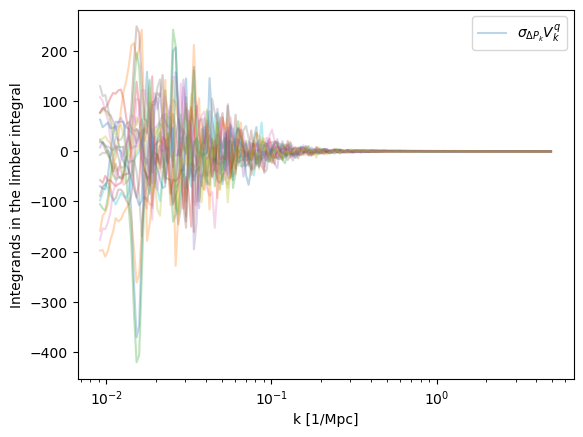

In [11]:
# Actually, I need to multiply vk[:, i] by data_std before doing the limber integral
# because data_std is a vector on k.

# Plot the components of Delta P_k (see notes).
# This quantity is what goes into the Limber integral
for i in range(index):
    DeltaPk_part1 = data_std * vk[:, i] 
    plt.semilogx(kMpc_common, DeltaPk_part1, alpha=0.3,
                 label=r'$\sigma_{\Delta P_k} V^q_k$' if i ==0 else '')
# plt.semilogx(kMpc_common, data_mean, color='k', alpha=0.5, label='$<\Delta P_k>$')
plt.xlabel('k [1/Mpc]')
plt.ylabel('Integrands in the limber integral')
plt.legend()
plt.show()
plt.close()

# Generate covariance

In [12]:
s = sacc.Sacc.load_fits('../data/cls_cov_GNG.fits')
s.keep_selection(data_type='cl_ee')

# Redshift shifts
dz_shifts = {'DESY3wl__0': 0,
             'DESY3wl__1': 0,
             'DESY3wl__2': 0, 
             'DESY3wl__3': 0,
            }

# Multiplicative bias
m_wl = {'DESY3wl__0': -0.0063,
         'DESY3wl__1': -0.0198,
         'DESY3wl__2': -0.0241, 
         'DESY3wl__3': -0.0369,
        }
m_wl = dz_shifts.copy()


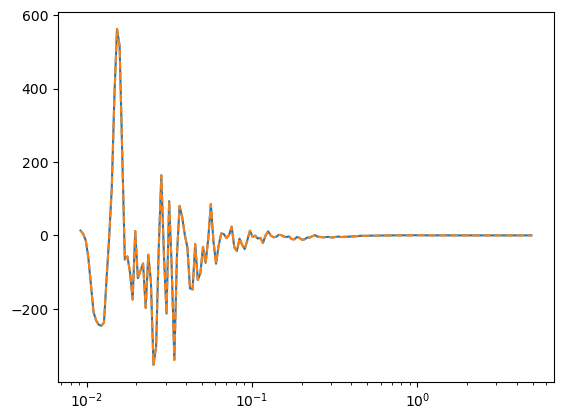

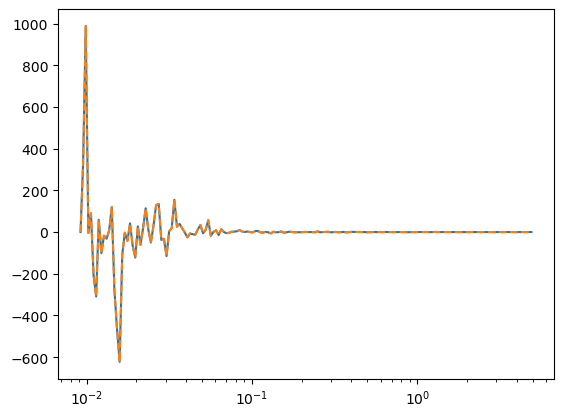

In [46]:
# Generate the ccl.Pk2D object, assuming a  constant error Delta Pk accross redshift
a_arr = np.linspace(1, 1/(1+3), 20)[::-1]
ones = np.ones_like(a_arr)
vk_x_data_std_pk2d = []

# Iterate over the eigenvectors to get the Pk2D objects
# We need to multiply the eigenvectors by data_std to do the integrals properly
for vki in vk.T:
    pk_arr = data_std[:, None] * vki[:, None] * ones
    vk_x_data_std_pk2d.append(ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(kMpc_common), pk_arr=pk_arr.T, is_logp=False))
    
# Get the Pk2D object for the data mean
pk_arr = data_mean[:, None] * ones
data_mean_pk2d = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(kMpc_common), pk_arr=pk_arr.T, is_logp=False)

# Check the interpolation
plt.semilogx(kMpc_common, data_mean)
plt.semilogx(kMpc_common, data_mean_pk2d(kMpc_common, 0.26), ls='--')
plt.show()
plt.close()

# Check the interpolation
plt.semilogx(kMpc_common, data_std * vki)
plt.semilogx(kMpc_common, vk_x_data_std_pk2d[-1](kMpc_common, 0.26), ls='--')
plt.show()
plt.close()

## DESY3__0 only

Projecting eigenvectors
Projecting for tracer combination ('DESY3wl__0', 'DESY3wl__0')
Projecting eigenvector number = 0


/home/ardok/mambaforge/envs/thcov/lib/python3.9/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/home/ardok/mambaforge/envs/thcov/lib/python3.9/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


Projecting eigenvector number = 1
Projecting eigenvector number = 2
Projecting eigenvector number = 3
Projecting eigenvector number = 4
Projecting eigenvector number = 5
Projecting eigenvector number = 6
Projecting eigenvector number = 7
Projecting eigenvector number = 8
Projecting eigenvector number = 9
Projecting eigenvector number = 10
Projecting eigenvector number = 11
Projecting eigenvector number = 12
Projecting eigenvector number = 13
Projecting eigenvector number = 14
Projecting eigenvector number = 15
Projecting eigenvector number = 16
Projecting eigenvector number = 17
Projecting eigenvector number = 18
Projecting eigenvector number = 19
Computing covariance matrix


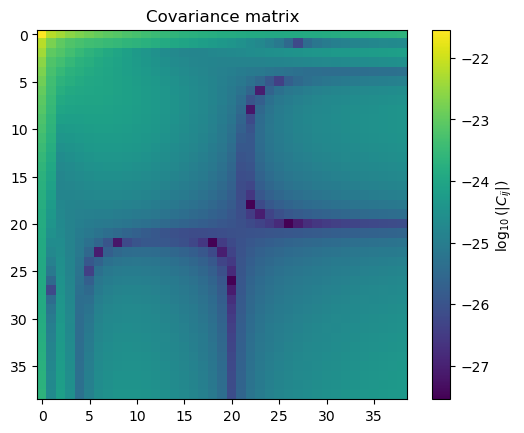

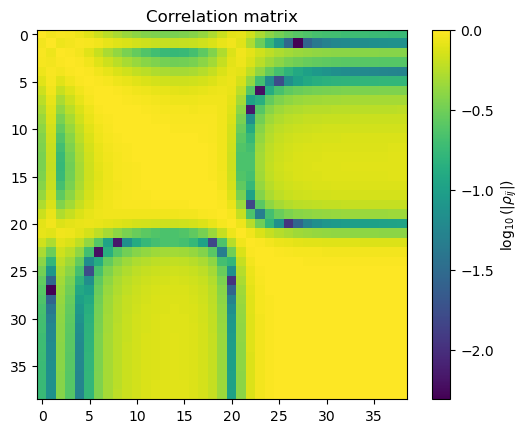

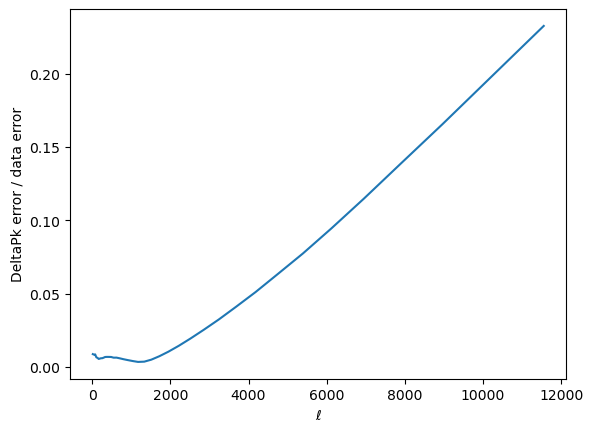

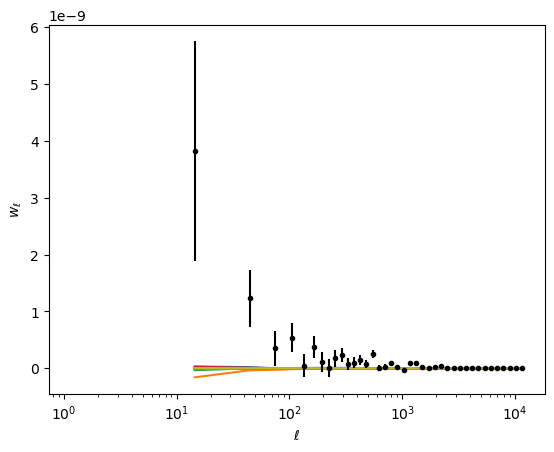

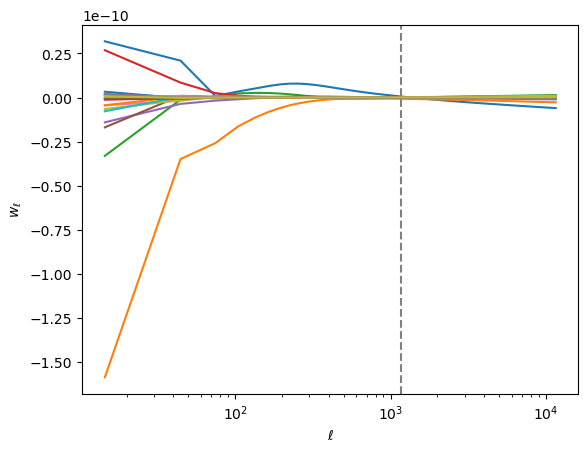

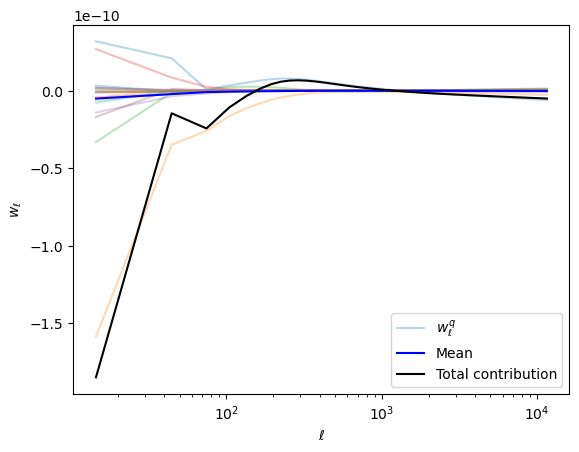

In [85]:
s1 = s.copy()
# For the test, lest keep only one tracer
s1.keep_tracers(['DESY3wl__0'])


N = 19 # select the number of principal components
vk_sigma = 0.1
data_mean_sigma = vk_sigma
m_sigma = None
cov, wl = get_cov(s1, evk=evk[:N], vk_x_data_std_pk2d=vk_x_data_std_pk2d[:N],
                  data_mean_pk2d=data_mean_pk2d,
                  dz_shifts=dz_shifts,
                  m_wl=m_wl,
                  vk_sigma=vk_sigma, data_mean_sigma=data_mean_sigma, m_sigma=m_sigma,
                  return_wl=True)
        
# Plot covariance
plt.imshow(np.log10(np.abs(cov)))
c = plt.colorbar()
c.set_label('$\log_{10}(|C_{ij}|)$')
plt.title('Covariance matrix')
plt.show()
plt.close()

# Plot correlation matrix
corr = cov / np.sqrt(np.diag(cov)[:, None] * np.diag(cov)[None, :])
plt.imshow(np.log10(np.abs(corr)))
c = plt.colorbar()
c.set_label('$\log_{10}(|\\rho_{ij}|)$')
plt.title('Correlation matrix')
plt.show()
plt.close()

# Plot the projected eigenvectors (wl)
ell, cl, cl_cov = s.get_ell_cl('cl_ee', 'DESY3wl__0', 'DESY3wl__0', return_cov=True)
err = np.sqrt(np.diag(cl_cov))

# Plot the error from the DeltaPk covariance respect to the value of the data error
plt.plot(ell, np.sqrt(np.diag(cov))/err)
plt.xlabel('$\ell$')
plt.ylabel('DeltaPk error / data error')
plt.show()
plt.close()

for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i])
plt.errorbar(ell, cl, yerr=err, color='k', fmt='.')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.show()
plt.close()

for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i])
plt.axvline(ell[20], ls='--', color='gray')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.show()
plt.close()


for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i], alpha=0.3, label='$w_\ell^q$' if i==0 else '')
plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][-1], color='blue', label='Mean')

wlfinal = np.sum(wl['DESY3wl__0', 'DESY3wl__0'], axis=0)
plt.semilogx(ell, wlfinal, color='k', label='Total contribution')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.legend()
plt.show()
plt.close()


In [84]:
N = None # select the number of principal components
vk_sigma = 0.1
data_mean_sigma = vk_sigma
m_sigma = None
cov, wl = get_cov(s1, evk=evk[:N], vk_x_data_std_pk2d=vk_x_data_std_pk2d[:N],
                  data_mean_pk2d=data_mean_pk2d, 
                  dz_shifts=dz_shifts,
                  m_wl=m_wl,
                  vk_sigma=vk_sigma, data_mean_sigma=data_mean_sigma, m_sigma=m_sigma,
                  return_wl=True)
        
# Plot covariance
plt.imshow(np.log10(np.abs(cov)))
c = plt.colorbar()
c.set_label('$\log_{10}(|C_{ij}|)$')
plt.title('Covariance matrix')
plt.show()
plt.close()

# Plot correlation matrix
corr = cov / np.sqrt(np.diag(cov)[:, None] * np.diag(cov)[None, :])
plt.imshow(np.log10(np.abs(corr)))
c = plt.colorbar()
c.set_label('$\log_{10}(|\\rho_{ij}|)$')
plt.title('Correlation matrix')
plt.show()
plt.close()

# Plot the projected eigenvectors (wl)
ell, cl, cl_cov = s.get_ell_cl('cl_ee', 'DESY3wl__0', 'DESY3wl__0', return_cov=True)
err = np.sqrt(np.diag(cl_cov))

# Plot the error from the DeltaPk covariance respect to the value of the data error
plt.plot(ell, np.sqrt(np.diag(cov))/err)
plt.xlabel('$\ell$')
plt.ylabel('DeltaPk error / data error')
plt.show()
plt.close()

for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i])
plt.errorbar(ell, cl, yerr=err, color='k', fmt='.')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.show()
plt.close()

for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i])
plt.axvline(ell[20], color='gray', ls='--')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.show()
plt.close()


for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i], alpha=0.3, label='$w_\ell^q$' if i==0 else '')
plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][-1], color='blue', label='Mean')

wlfinal = np.sum(wl['DESY3wl__0', 'DESY3wl__0'], axis=0)
plt.semilogx(ell, wlfinal, color='k', label='Total contribution')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.legend()
plt.show()
plt.close()

Projecting eigenvectors
Projecting for tracer combination ('DESY3wl__0', 'DESY3wl__0')
Projecting eigenvector number = 0


/home/ardok/mambaforge/envs/thcov/lib/python3.9/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


Projecting eigenvector number = 1
Projecting eigenvector number = 2
Projecting eigenvector number = 3
Projecting eigenvector number = 4
Projecting eigenvector number = 5
Projecting eigenvector number = 6
Projecting eigenvector number = 7
Projecting eigenvector number = 8
Projecting eigenvector number = 9
Projecting eigenvector number = 10
Projecting eigenvector number = 11


KeyboardInterrupt: 

In [83]:
ell[20]

1172.0000000000016

### Check we project the DeltaPk correctly [we do, hurray!]

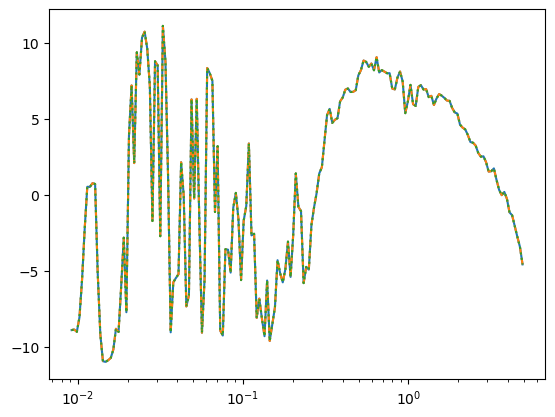

In [75]:
# How to multiply the eigenvectors and eigenvalues to get Delta Pk
dpk = np.zeros(evk.size)
for i in range(evk.size):
    dpk += evk[i] * vk[:, i]
plt.plot(kMpc_common, dpk)
plt.plot(kMpc_common, np.sum(evk[:, None]*vk.T, axis=0), ls='--')
plt.plot(kMpc_common, np.matmul(evk, vk.T), ls=':')
plt.semilogx()
plt.show()
plt.close()

Projecting eigenvectors
Projecting for tracer combination ('DESY3wl__0', 'DESY3wl__0')
Projecting eigenvector number = 0


/home/ardok/mambaforge/envs/thcov/lib/python3.9/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/home/ardok/mambaforge/envs/thcov/lib/python3.9/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


Projecting eigenvector number = 1
Computing covariance matrix


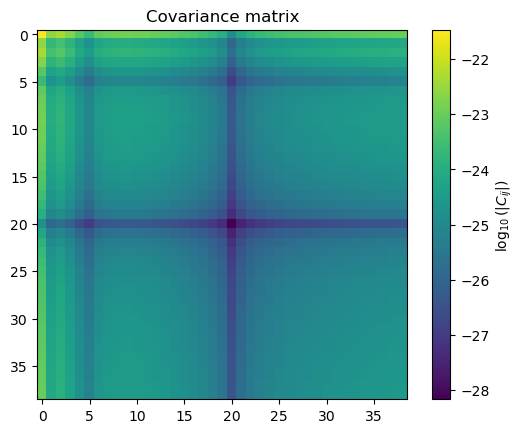

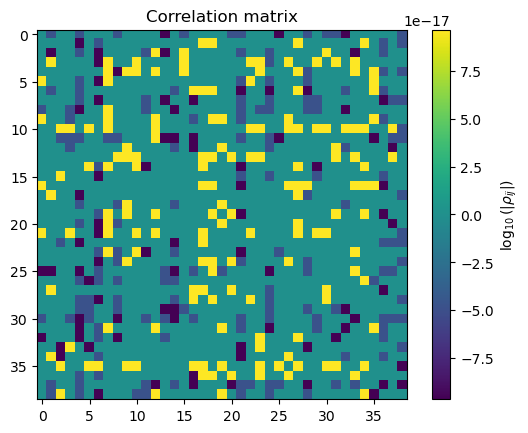

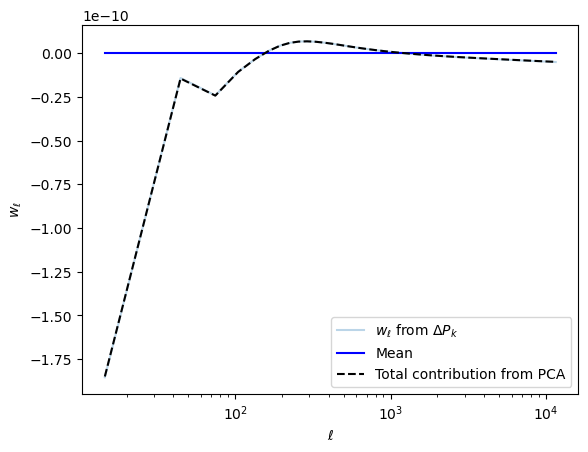

In [81]:
# Check covariance matrix
# 1. Let's check that the wl_total is actually the projection of Delta Pk

# Obtain DeltaPk from the eigenvectors and eigenvalues
# TODO: is np.matmul(evk, vk.T) correct? it gives the same as the for loop as I would do it, but not sure
pk_arr = (data_std * np.matmul(evk, vk.T) + data_mean)[:, None] * ones
DeltaPk_pk2d = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(kMpc_common), pk_arr=pk_arr.T, is_logp=False)
    
# Get the Pk2D object for the data mean
pk_arr = data_mean[:, None] * np.zeros_like(ones)
zeros_Pk2d = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(kMpc_common), pk_arr=pk_arr.T, is_logp=False)

s1 = s.copy()
# For the test, lest keep only one tracer
s1.keep_tracers(['DESY3wl__0'])

N = None # select the number of principal components
vk_sigma = 0.1
data_mean_sigma = vk_sigma
m_sigma = None


cov, wl = get_cov(s1, evk=[1], vk_x_data_std_pk2d=[DeltaPk_pk2d],
                  data_mean_pk2d=zeros_Pk2d,
                  dz_shifts=dz_shifts,
                  m_wl=m_wl,
                  vk_sigma=vk_sigma, data_mean_sigma=data_mean_sigma, m_sigma=m_sigma,
                  return_wl=True)
        
# Not plotting the covariance because it mixes terms that we know should be 
# uncorrelated due to the PCA.

# Plot covariance
plt.imshow(np.log10(np.abs(cov)))
c = plt.colorbar()
c.set_label('$\log_{10}(|C_{ij}|)$')
plt.title('Covariance matrix')
plt.show()
plt.close()

# Plot correlation matrix
corr = cov / np.sqrt(np.diag(cov)[:, None] * np.diag(cov)[None, :])
plt.imshow(np.log10(np.abs(corr)))
c = plt.colorbar()
c.set_label('$\log_{10}(|\\rho_{ij}|)$')
plt.title('Correlation matrix')
plt.show()
plt.close()

# Plot the projected eigenvectors (wl)
ell, cl, cl_cov = s1.get_ell_cl('cl_ee', 'DESY3wl__0', 'DESY3wl__0', return_cov=True)
err = np.sqrt(np.diag(cl_cov))

plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][0], alpha=0.3, label='$w_\ell$ from $\Delta P_k$')
plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][-1], color='blue', label='Mean')

# Plot wlfinal obtained in previous Cell
plt.semilogx(ell, wlfinal, color='k', ls='--', label='Total contribution from PCA')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.legend()
plt.show()
plt.close()


Projecting eigenvectors
Projecting for tracer combination ('DESY3wl__0', 'DESY3wl__0')


/home/ardok/mambaforge/envs/thcov/lib/python3.9/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


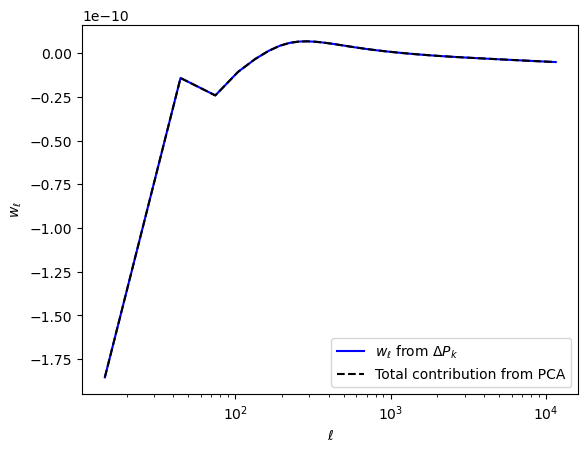

In [64]:
# Let's project the DeltaPk by hand

# Obtain DeltaPk from the eigenvectors and eigenvalues
pk_arr = (data_std * np.matmul(evk, vk.T) + data_mean)[:, None] * ones
DeltaPk_pk2d = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(kMpc_common), pk_arr=pk_arr.T, is_logp=False)

# Initialize cosmology
cosmo = ccl.CosmologyVanillaLCDM()

# Instatiate the ccl tracers
ccl_tracers = {}
z = np.linspace(0, 4, 100)

for trn, trv in s1.tracers.items():
    dndz = interp1d(trv.z, trv.nz, bounds_error=False, fill_value=0) # Interpolate the dndz
    ccl_tracers[trn] = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz(z - dz_shifts[trn])), has_shear=True, ia_bias=None)
    
    
# Project the eigenvectors
print("Projecting eigenvectors", flush=True)
for trs in s1.get_tracer_combinations():
    print("Projecting for tracer combination {}".format(trs), flush=True)
    ix = s1.indices(tracers=trs)
    bpw = s1.get_bandpower_windows(ix)
    l_bpw = bpw.values
    w_bpw = bpw.weight.T
    cl = ccl.angular_cl(cosmo, ccl_tracers[trs[0]], ccl_tracers[trs[1]], l_bpw, p_of_k_a=DeltaPk_pk2d, limber_integration_method="spline")
    wl_DeltaPk = ((1 + m_wl[trs[0]]) * (1 + m_wl[trs[1]]) * w_bpw.dot(cl))

# Plot wlfinal obtained in previous Cell
plt.semilogx(ell, wl_DeltaPk, color='blue', ls='-', label='$w_\ell$ from $\Delta P_k$')
plt.semilogx(ell, wlfinal, color='k', ls='--', label='Total contribution from PCA')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.legend()
plt.show()
plt.close()


## All DESY3wl

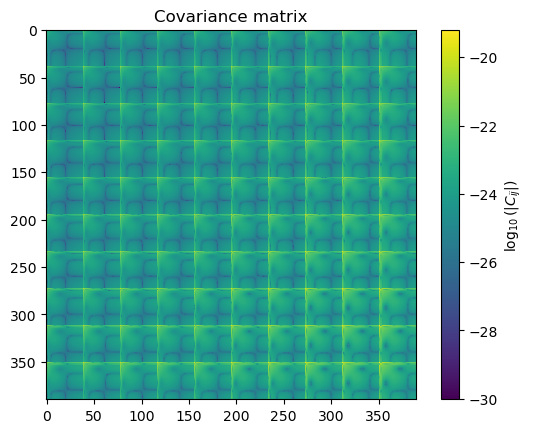

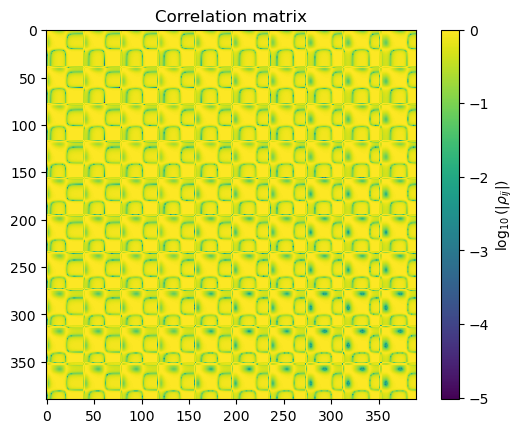

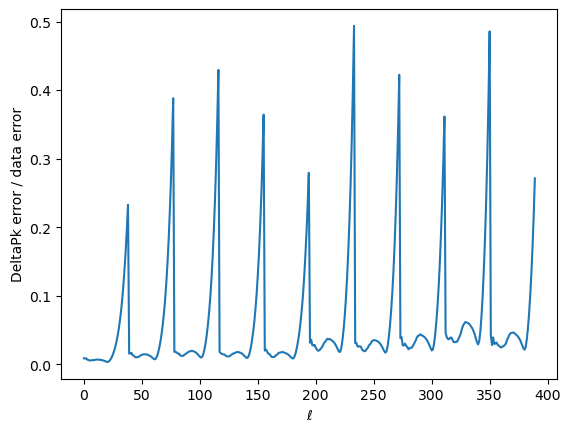

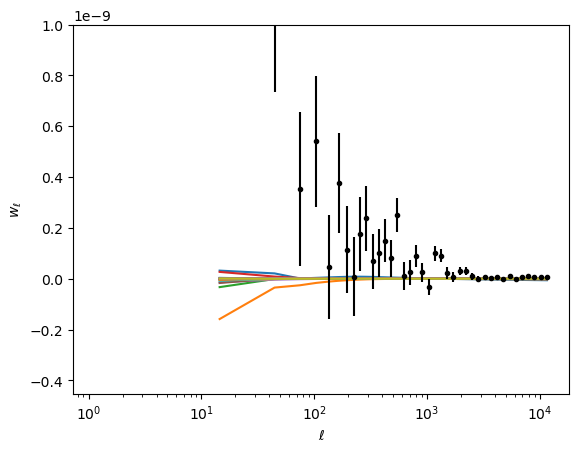

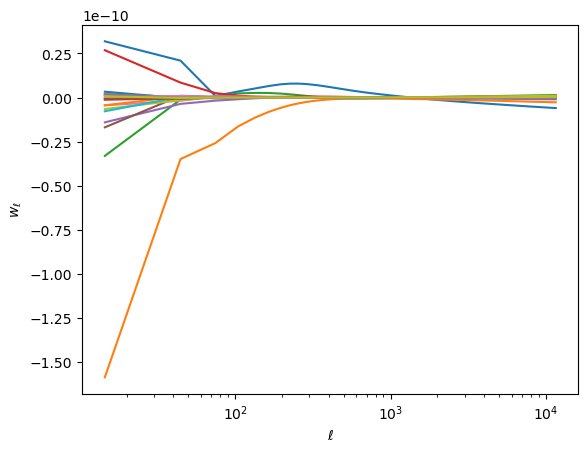

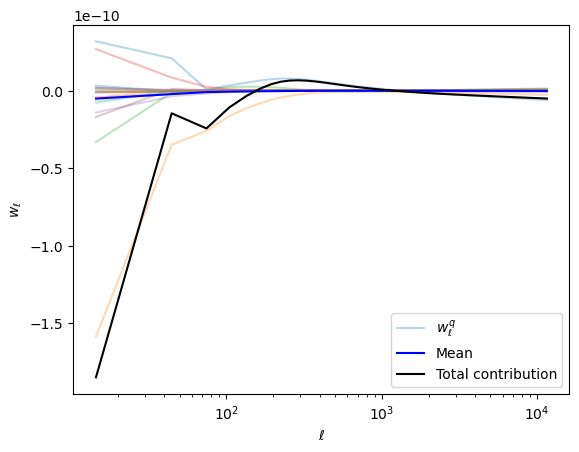

In [80]:
N = 19 # select the number of principal components
vk_sigma = 0.1
data_mean_sigma = vk_sigma
m_sigma = None
cov, wl = get_cov(s, evk=evk[:N], vk_x_data_std_pk2d=vk_x_data_std_pk2d[:N],
                  data_mean_pk2d=data_mean_pk2d,
                  dz_shifts=dz_shifts,
                  m_wl=m_wl,
                  vk_sigma=vk_sigma, data_mean_sigma=data_mean_sigma, m_sigma=m_sigma,
                  return_wl=True)
        
# Plot covariance
plt.imshow(np.log10(np.abs(cov)))
c = plt.colorbar()
c.set_label('$\log_{10}(|C_{ij}|)$')
plt.title('Covariance matrix')
plt.show()
plt.close()

# Plot correlation matrix
corr = cov / np.sqrt(np.diag(cov)[:, None] * np.diag(cov)[None, :])
plt.imshow(np.log10(np.abs(corr)))
c = plt.colorbar()
c.set_label('$\log_{10}(|\\rho_{ij}|)$')
plt.title('Correlation matrix')
plt.show()
plt.close()


# Plot the error from the DeltaPk covariance respect to the value of the data error
plt.plot(np.sqrt(np.diag(cov))/np.sqrt(np.diag(s.covariance.covmat)))
plt.xlabel('$\ell$')
plt.ylabel('DeltaPk error / data error')
plt.show()
plt.close()

# Plot the projected eigenvectors (wl)
ell, cl, cl_cov = s.get_ell_cl('cl_ee', 'DESY3wl__0', 'DESY3wl__0', return_cov=True)
err = np.sqrt(np.diag(cl_cov))

for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i])
plt.errorbar(ell, cl, yerr=err, color='k', fmt='.')
plt.ylim(None, 1e-9)
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.show()
plt.close()

for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i])
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.show()
plt.close()


for i in range(evk[:N].size):
    plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][i], alpha=0.3, label='$w_\ell^q$' if i==0 else '')
plt.semilogx(ell, wl['DESY3wl__0', 'DESY3wl__0'][-1], color='blue', label='Mean')

wlfinal = np.sum(wl['DESY3wl__0', 'DESY3wl__0'], axis=0)
plt.semilogx(ell, wlfinal, color='k', label='Total contribution')
plt.xlabel('$\ell$')
plt.ylabel('$w_\ell$')
plt.legend()
plt.show()
plt.close()

In [20]:
import pytest
cov == pytest.approx(cov.T, rel=1e-10)

True